In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
np.set_printoptions(precision=5,threshold=sys.maxsize)
import glob as glob
#from natsort import natsorted # not compatible with current setup 

unit_base = {'UnitMagneticField_in_gauss':  1e+4,
             'UnitLength_in_cm'         : 3.08568e+18,
             'UnitMass_in_g'            :   1.989e+33,
             'UnitVelocity_in_cm_per_s' :      100}

In [48]:
# Read in Data From a single csv file

#tag = 'M2e3_mid_prop.csv'
#tag = '_snapshot400_min1e3/snapshot400_prop.csv'

tag = '_M2e3_cores/M2e3_R3_S0-T1_B0.01_Res126_n2_sol0.5_42_snapshot_1.540_120_prop_v2.csv'

converter_nparray = lambda x: np.array(x[1:-1].split(), dtype = float)

profiles = pd.read_csv(tag, 
                       converters = {'Radii': converter_nparray,
                                     'Density [cm^-3]': converter_nparray,
                                    'Dispersion [cm/s]': converter_nparray,
                                    'V Bulk [cm/s]': converter_nparray,
                                    'Center Position [pc]':converter_nparray,
                                    'Eigenvals [pc]':converter_nparray,
                                     'Mean B [G]':converter_nparray
                                    #'Eigenvecs':converter_nparray
                                    #'Sink Masses [Msun]':converter_nparray
                                    })

In [67]:
# Read in Data From Folder of csv files

tag = '_M2e3_cores_v2/M2e3_R3_S0-T1_B0.01_Res126_n2_sol0.5_42_snapshot_*_prop_v2.csv'
file_save = '_M2e3_cores_v2/M2e3_R3_S0-T1_B0.01_Res126_n2_sol0.5_42_all_prop_v2.csv'
time_save = '_M2e3_cores_v2/M2e3_R3_S0-T1_B0.01_Res126_n2_sol0.5_42_times.csv'

fns = glob.glob(tag)
fns.sort() # Will need natsort for snapshot > 1000 (unless it sorts on time ...)

converter_nparray = lambda x: np.array(x[1:-1].split(), dtype = float)

frames = []
times = []
for fn in fns:
    data = pd.read_csv(fn, 
                       converters = {'Radii': converter_nparray,
                                     'Density [cm^-3]': converter_nparray,
                                    'Dispersion [cm/s]': converter_nparray,
                                    'V Bulk [cm/s]': converter_nparray,
                                    'Center Position [pc]':converter_nparray,
                                    'Eigenvals [pc]':converter_nparray,
                                     'Mean B [G]':converter_nparray
                                    #'Eigenvecs':converter_nparray
                                    #'Sink Masses [Msun]':converter_nparray
                                    })
    frames.append(data)
    time = np.float(fn[-18:-14])
    times.append(time)
    
profiles = pd.concat(frames)


if 1: # Save all as a new data frame
    
    save_df = pd.DataFrame(profiles, columns = ['ID','Density [cm^-3]','Dispersion [cm/s]', 'Reff [pc]', 'LeafDisp [cm/s]', 'LeafMass [msun]', 'CoherentRadius [pc]',
                                                'DensityIndex','V Bulk [cm/s]','Center Position [pc]','Center index','LeafKe', 'LeafGrav', 'Num. Sinks',
                                                'Max Den [cm^-3]', 'Eigenvals [pc]', 'Eigenvecs', 'Half Mass R[pc]', 'Mean B [G]', 'Mag. Energy', 'Sink Masses [Msun]',
                                                'Sound speed [cm/s]'])
    print("Saving cores in ", file_save)
    save_df.to_csv(file_save,index=False)

Saving cores in  _M2e3_cores_v2/M2e3_R3_S0-T1_B0.01_Res126_n2_sol0.5_42_all_prop_v2.csv


In [46]:
df = pd.DataFrame({'Time [Myr]': times})
df.to_csv(time_save,index=False)

In [68]:
print(len(profiles))
print(len(np.unique(profiles['ID'].values)))

5404
5404


In [69]:
# Grab the arrays
#'ID','Density [cm^-3]','Dispersion [m/s]', 'Reff [pc]', 'LeafDisp [m/s]', 'LeafMass [msun]', 'CoherentRadius [pc]',
#'DensityIndex','V Bulk [m/s]','Center Position [pc]','Center index','LeafKe', 'LeafGrav', 'Num. Sinks',
#'Max Den [cm^-3]', 'Eigenvals [pc]', 'Eigenvecs', 'Half Mass R[pc]', 'Mean B [T]', 'Mag. Energy', 'Sink Masses [Msun]',
#'Sound speed [cm/s]'

ID = profiles['ID'].values
density = profiles['Density [cm^-3]'].values
veldisp = profiles['Dispersion [cm/s]'].values
# Bulk properties
lradius = np.array(profiles['Reff [pc]'].values)
rcoh = profiles['CoherentRadius [pc]'].values # Calculated from profile
rhopow = profiles['DensityIndex'].values # Calculated from profile
lvbulk = profiles['V Bulk [cm/s]'].values
ldisp = profiles['LeafDisp [cm/s]'].values
lmass = profiles['LeafMass [msun]'].values
lcenter = profiles['Center Position [pc]'].values
lidx = profiles['Center index'].values
lmax = profiles['Max Den [cm^-3]'].values
leigenvals = profiles['Eigenvals [pc]'].values
leigenvecs = profiles['Eigenvecs'].values
lhalf = profiles['Half Mass R[pc]'].values
lb = profiles['Mean B [G]'].values

lke = profiles['LeafKe'].values #Still in code units
lgrave = profiles['LeafGrav'].values #Still in code units
lmage = profiles['Mag. Energy'].values #Still in code units
lsink = profiles['Num. Sinks'].values
lsinkmass = profiles['Sink Masses [Msun]'].values
lsound = profiles['Sound speed [cm/s]'].values # in m/s
#lkeonly = profiles['LeafKe only'].values # in m/s

nleaves = len(lsound)
indsink = np.where(lsink > 0)[0]
indnosink = np.where(lsink == 0)[0]
sinkfrac = len(indsink)/nleaves
# Interpolate the profiles and store the results (in a format compatible with sklearn PCA)
## the common grid used for the interpolation
#size_grid = np.log10(np.logspace(np.log10(1.0e-2), np.log10(1.5e-1), 50))

# Some corrections (Now done in get_prop)
#lmage_cgs = np.array(np.float128(np.array(lmage))*np.float128(unit_base['UnitMagneticField_in_gauss']**2)*unit_base['UnitLength_in_cm']**3*(4.0/3.0*np.pi)*np.array(lradius)**3)
#lke_cgs = np.float128(np.array(lke))*np.float128(unit_base['UnitMass_in_g']*unit_base['UnitVelocity_in_cm_per_s']**2)
lgrave = np.abs(lgrave)
lmeanv = []
lmeanb = []
for i in range(len(lsound)):
    lmeanv.append(np.sqrt(np.sum(lvbulk[i]**2)))
    lmeanb.append(np.sqrt(np.sum(lb[i]**2)))

lmeanb = np.array(lmeanb)
lmeanv = np.array(lmeanv)

In [50]:
np.set_printoptions(precision=2, suppress=2, threshold=2)

kms = 1e3
ug = 1e6 # G -> uG
print("Simulation Core statistics (%i cores):" %len(lmass))
print(" M (Msun)        = %5.3f %5.3f %5.3f" %(np.mean(lmass), np.median(lmass), np.std(lmass)))
print(" R (pc)          = %5.3f %5.3f %5.3f" %(np.mean(lradius), np.median(lradius), np.std(lradius) ))
print(" Max den (cm^-3) = %5.3f %5.3f %5.3f" %(np.mean(lmax), np.median(lmax), np.std(lmax) ))
print(" Half Max (pc)   = %5.3f %5.3f %5.3f" %(np.mean(lhalf), np.median(lhalf), np.std(lhalf) ))
print(" Mean B (uG)     = ", np.average(lb, axis=0)*ug), np.sqrt(np.sum(np.average(lb, axis=0)*ug,axis=0)**2)#, np.median(lb, axis=0)/uG) #, np.std(lb, axis=0)/ug )
#print(" Mean Brms (uG)     = %5.3f" %np.mean(lmeanb)*ug)
print(" 3D Vdisp (km/s) = %5.3f %5.3f %5.3f" %(np.mean(ldisp)/kms, np.median(ldisp)/kms, np.std(ldisp)/kms))
print(" Rcoh (pc)       = %5.3f %5.3f %5.3f" %(np.mean(rcoh), np.median(rcoh), np.std(rcoh)))
print(" Den Power Law   = %5.3f %5.3f %5.3f" %(np.mean(rhopow), np.median(rhopow), np.std(rhopow)))
print(" Sound Speed     = %5.3f %5.3f %5.3f" %(np.mean(lsound)/kms, np.median(lsound), np.std(lsound)/kms))
print("**")
print(" KE    = %5.3e %5.3e %5.3e" %(np.mean(lke), np.median(lke), np.std(lke)))
print(" Mage  = %5.3e %5.3e %5.3e" %(np.mean(lmage), np.median(lmage), np.std(lmage))) 
print(" Grave  = %5.3e %5.3e %5.3e" %(np.mean(lgrave), np.median(lgrave), np.std(lgrave))) 
print(" Mage/KE  = %5.4f %5.4f %5.4f" %(np.mean(lmage/lke), np.median(lmage/lke), np.std(lmage/lke))) 
print(" Grave/KE  = %5.4f %5.4f %5.4f" %(np.mean(lke/lgrave), np.median(lke/lgrave), np.std(lke/lgrave))) 
print(" SinkFrac = %5.3f" %sinkfrac)


Simulation Core statistics (158 cores):
 M (Msun)        = 0.589 0.314 0.686
 R (pc)          = 0.087 0.061 0.077
 Max den (cm^-3) = 107377837.725 68307.520 552501652.488
 Half Max (pc)   = 0.048 0.034 0.041
 Mean B (uG)     =  [48.41 58.03 39.2 ]
 3D Vdisp (km/s) = 23.870 20.229 13.763
 Rcoh (pc)       = 0.046 0.033 0.051
 Den Power Law   = -0.130 -0.055 0.208
 Sound Speed     = 0.139 128.096 0.025
**
 KE    = 9.988e+41 3.513e+41 1.847e+42
 Mage  = 3.713e+41 1.271e+41 6.711e+41
 Grave  = 5.143e+42 1.378e+42 9.697e+42
 Mage/KE  = 0.4542 0.3640 0.3356
 Grave/KE  = 0.3333 0.2461 0.3168
 SinkFrac = 0.152


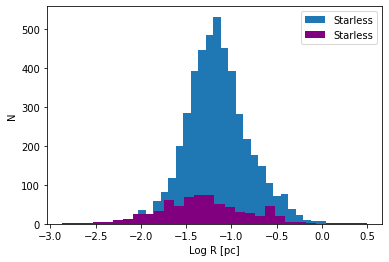

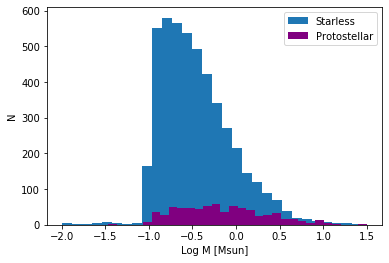

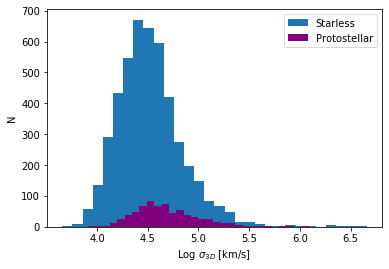

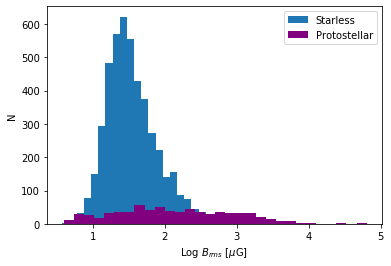

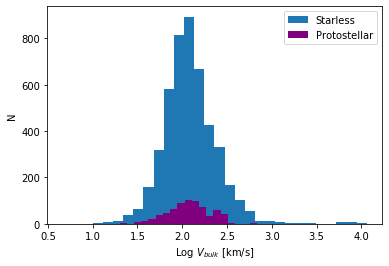

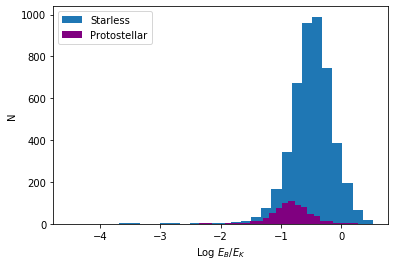

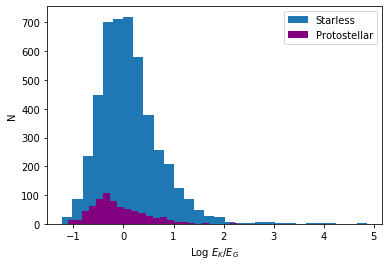

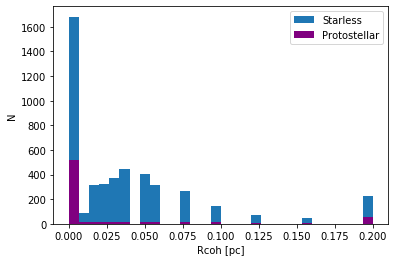

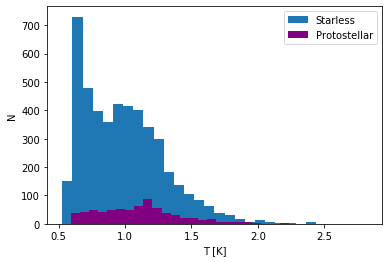

All: slope, offset: [0.74402 0.45625] [0.01223 0.01502]
Protostellar: slope, offset: [0.71388 0.76143] [0.02627 0.0365 ]


In [70]:
# the histograms of the data

# Radius
fig, ax = plt.subplots()
n, bins, patches = ax.hist(np.log10(lradius[indnosink]), 30, stacked=True, label='Starless')
n, bins, patches = ax.hist(np.log10(lradius[indsink]), 30, stacked=True, color='purple', label='Starless')
ax.set_xlabel('Log R [pc]')
ax.set_ylabel('N')
plt.legend()
plt.show()

# Mass
fig, ax = plt.subplots()
n, bins, patches = ax.hist(np.log10(lmass[indnosink]), 30, stacked=True,label='Starless')
n, bins, patches = ax.hist(np.log10(lmass[indsink]), 30, stacked=True, color='purple', label='Protostellar')
ax.set_xlabel('Log M [Msun]')
ax.set_ylabel('N')
plt.legend()
plt.show()

# Velocity Dispersion
fig, ax = plt.subplots()
n, bins, patches = ax.hist(np.log10(ldisp[indnosink]), 30, stacked=True, label='Starless')
n, bins, patches = ax.hist(np.log10(ldisp[indsink]), 30, stacked=True, color='purple', label='Protostellar')
ax.set_xlabel('Log $\sigma_{3D}$ [km/s]')
ax.set_ylabel('N')
plt.legend()
plt.show()

# Brms
fig, ax = plt.subplots()
n, bins, patches = ax.hist(np.log10(lmeanb[indnosink]*ug), 30, stacked=True, label='Starless')
n, bins, patches = ax.hist(np.log10(lmeanb[indsink]*ug), 30, stacked=True, color='purple', label='Protostellar')
ax.set_xlabel('Log $B_{rms}$ [$\mu$G]')
ax.set_ylabel('N')
plt.legend()
plt.show()

# Vrms bulk 
fig, ax = plt.subplots()
n, bins, patches = ax.hist(np.log10(lmeanv[indnosink]/kms), 30, stacked=True, label='Starless')
n, bins, patches = ax.hist(np.log10(lmeanv[indsink]/kms), 30, stacked=True, color='purple', label='Protostellar')
ax.set_xlabel('Log $V_{bulk}$ [km/s]')
ax.set_ylabel('N')
plt.legend()
plt.show()

# Ratio of EB/KE
fig, ax = plt.subplots()
n, bins, patches = ax.hist(np.log10(lmage[indnosink]/lke[indnosink]), 30, stacked=True, label='Starless')
n, bins, patches = ax.hist(np.log10(lmage[indsink]/lke[indsink]), 30, stacked=True, color='purple', label='Protostellar')
ax.set_xlabel('Log $E_B/E_K$')
ax.set_ylabel('N')
plt.legend()
plt.show()

# Ratio of EB/KE
# Note CloudPhinder defines virial parameter as 2*KE/PE
fig, ax = plt.subplots()
n, bins, patches = ax.hist(np.log10(2*lke[indnosink]/lgrave[indnosink]), 30, stacked=True, label='Starless')
n, bins, patches = ax.hist(np.log10(2*lke[indsink]/lgrave[indsink]), 30, stacked=True, color='purple', label='Protostellar')
ax.set_xlabel('Log $E_K/E_G$')
ax.set_ylabel('N')
plt.legend()
plt.show()

# Rcoh
fig, ax = plt.subplots()
n, bins, patches = ax.hist(rcoh[indnosink], 30, stacked=True, label='Starless')
n, bins, patches = ax.hist(rcoh[indsink], 30, stacked=True, color='purple', label='Protostellar')
ax.set_xlabel('Rcoh [pc]')
ax.set_ylabel('N')
plt.legend()
plt.show()


# Mean Temp
temp = (lsound*1e2)**2*2.33*1.667e-24/1.38e-16
fig, ax = plt.subplots()
n, bins, patches = ax.hist(np.log10(temp[indnosink]), 30, stacked=True, label='Starless')
n, bins, patches = ax.hist(np.log10(temp[indsink]), 30, stacked=True, color='purple', label='Protostellar')
ax.set_xlabel('T [K]')
ax.set_ylabel('N')
plt.legend()
plt.show()

coeff, cov = np.polyfit(np.log10(lradius), np.log10(lmass), 1, cov='True')
print("All: slope, offset:", coeff, np.sqrt(np.diag(cov)))

coeff, cov = np.polyfit(np.log10(lradius[indsink]), np.log10(lmass[indsink]), 1, cov='True')
print("Protostellar: slope, offset:", coeff, np.sqrt(np.diag(cov)))

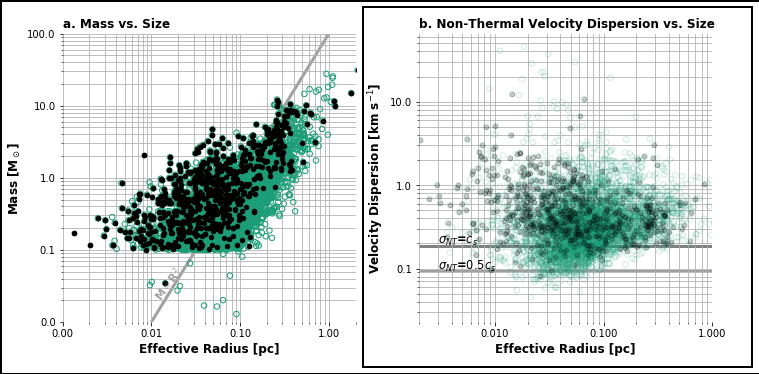

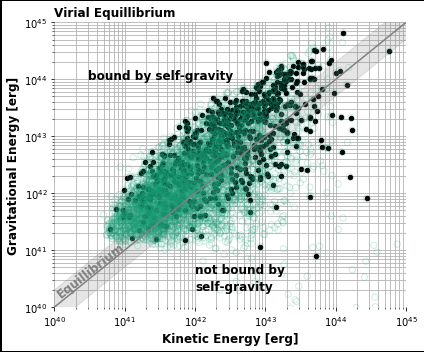

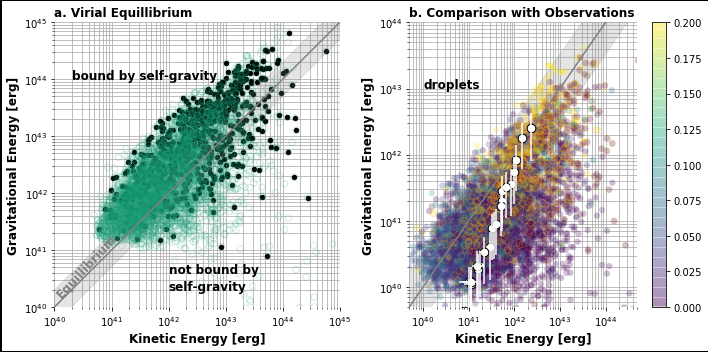

In [73]:
#Plot New Clusters
from matplotlib.ticker import ScalarFormatter

####
numk = 3  #Set this
####

#tags = (np.unique(clusterid3))#[0:2]
#ids = clusterid3
fname = "M2e3_test"
pc = 3.09e18

#colors = ['firebrick', 'cornflowerblue', 'limegreen']  #k=3
#colors = ['#66C2A5', '#FC8D62', '#8DA0CB'] colorbrewer
colors = ['#1B9E77', '#D95F02', '#7570B3'] #colorbrewer
#colors = ['#00AFBB', '#E7B800', '#FC4E07']
#colors = ['purple','firebrick', 'cornflowerblue','limegreen'] #k=4
import matplotlib as mpl
#mpl.rcParams['figure.linewidth'] = 5
#mpl.rcParams['figure.edgecolor'] = 'black'
fw = 3
lw = 3
tsz = 12

fig, ax = plt.subplots(1,2, edgecolor='black',frameon=True, linewidth=fw)
#https://e2eml.school/matplotlib_framing.html

print("Note some of the masses are less than < 0.1 because the cut is by particle number.") 
print(" feedback particles have less mass; most are also warmer and can be removed with mass cuts.")
i = 0
x = np.linspace(0.001, 2, 2)
#y = (10**0.46)*x**0.74 # Fit (see above)
y = (10**2.0)*x**2.0
ax[i].loglog(x,y, lw=lw, color='grey', alpha=0.75,zorder=0)
ax[i].text(0.01, 0.02, 'M$\propto$R$^2$',size=tsz*0.9, fontweight='bold', rotation=54, color='grey', alpha=0.75) #, colors=colors[0])

ax[i].scatter(lradius[lsink >= 1], lmass[lsink >= 1],  c='black', edgecolors='black', s=20)
#for j,tag in enumerate(tags):
#    ind = np.where(ids==tag)
#    for pl in ind[0]:
#        ax[i].scatter(cr[pl], cm[pl],  c='none', edgecolors=colors[j], s=30,alpha=weight3[pl])

ax[i].scatter(lradius*(temp < 80), lmass*(temp < 80),  c='none', edgecolors=colors[0], s=30)
ax[i].scatter(lradius[lsink >= 1], lmass[lsink >= 1],  c='black', edgecolors='black', s=20)
#ax[i].scatter(lhalf, lmass/2,  c='none', edgecolors=colors[0], s=30)
#ax[i].scatter(lhalf[lsink >= 1], lmass[lsink >= 1]/2.0,  c='black', edgecolors='black', s=20)


ax[i].set_yscale("log")
ax[i].set_xscale("log")
ax[i].grid(b=True, which='both')
ax[i].set_axisbelow(True)
ax[i].set_xlabel("Effective Radius [pc]", size=tsz, fontweight='bold')
ax[i].set_ylabel("Mass [M$_\odot$]", size=tsz, fontweight='bold')
ax[i].set_title("a. Mass vs. Size", size=tsz, fontweight='bold', loc='left')
ax[i].set_xlim(.001,2)
ax[i].set_ylim(0.01,100)
for axis in ['top','bottom','left','right']:
  ax[i].spines[axis].set_visible(False)    #.set_linewidth(0.0)

ax[i].yaxis.set_major_formatter(ScalarFormatter())
ax[i].xaxis.set_major_formatter(ScalarFormatter())
#ax[i].text(0.03, 0.05, 'Phase I',size=tsz, color=colors[0], fontweight='bold')#, colors=colors[0])
#ax[i].text(0.013, 1.01, 'Phase III',size=tsz, color=colors[1], fontweight='bold')#, colors=colors[0])
#ax[i].text(0.06, 0.25, 'Phase II',size=tsz, color=colors[2], fontweight='bold')#, colors=colors[0])
if numk == 4: ax[i].text(0.011, 0.05, '1.4',size=tsz, color=colors[3], fontweight='bold')#, colors=colors[0])

i = 1
#Mark the ones with sinks and the coherent ones
ax[i].scatter(lradius, ldisp/1e5, alpha=0.2, c='none', edgecolors=colors[0], s=30)
ax[i].scatter(lradius[lsink >= 1], ldisp[lsink >= 1]/1e5,  alpha=0.2, c='black', edgecolors='black', s=20)
#ax[i].scatter(cr[rcoh > 3.09e16/pc], cvdisp3d[rcoh > 3.09e16/pc],  c='grey', edgecolors='grey', s=20)
#for j,tag in enumerate(tags):
#    ind = np.where(ids==tag)
    #print("NOTE: This is (v1d^2 + cs^2)^0.5 turbulent dispersion in km/s")
#    for pl in ind[0]:
#        ax[i].scatter(cr[pl], cvdisp3d[pl], alpha=weight3[pl], c='none', edgecolors=colors[j], s=30)

#ax[i].text(-4.5, 4.0, 'Phase 1',size=12, fontweight='bold', colors=colors[0])
ax[i].set_yscale("log")
ax[i].set_xscale("log")
ax[i].grid(b=True, which='both')
ax[i].set_axisbelow(True)
ax[i].set_xlabel("Effective Radius [pc]", size=tsz, fontweight='bold')
cs=0.188
signt = cs #np.sqrt(cs**2+ cs**2) #Here cs is not added in quadrature
halfsignt = np.sqrt(cs**2+ (cs/2.0)**2)
ax[i].plot(np.array([0.001, 10]), np.ones(2)*cs, lw=lw, color='grey',zorder=0)
ax[i].plot(np.array([0.001, 10]), np.ones(2)*0.5*cs, lw=lw/2., color='grey',zorder=0)
ax[i].text(0.003, cs+0.01, '$\sigma_{NT}$=$c_s$',size=tsz*0.95, fontweight='bold', color='black') #, colors=colors[0])
ax[i].text(0.003, 0.5*cs+0.003, '$\sigma_{NT}$=$0.5c_s$',size=tsz*0.95,fontweight='bold', color='black') #, colors=colors[0])

# 0.3=sig_tot for sig_NT = cs, 0.325 = sig_tot for sig_NT = 0.5c_s


#ax[i][i].set_ylabel("$\sigma_{1D}$ [km$^{3}$/s]", size=14, fontweight='bold')
ax[i].set_ylabel("Velocity Dispersion [km s$^{-1}$]", size=tsz, fontweight='bold')
ax[i].set_title("b. Non-Thermal Velocity Dispersion vs. Size", size=tsz, fontweight='bold', loc='left')
ax[i].set_xlim(.002,1.0)
#ax[i].set_ylim(0.045,2)
for axis in ['top','bottom','left','right']:
  ax[i].spines[axis].set_visible(False)

#ax[i].text(0.05, 1.5, 'Phase I',size=tsz, color=colors[0], fontweight='bold')#, colors=colors[0])
#ax[i].text(0.011, 1.5, 'Phase III',size=tsz, color=colors[1], fontweight='bold')#, colors=colors[0])
#ax[i].text(0.05, 0.07, 'Phase II',size=tsz, color=colors[2], fontweight='bold')#, colors=colors[0])
if numk == 4: ax[i].text(0.011, 0.05, '1.4',size=tsz, color=colors[3], fontweight='bold')#, colors=colors[0])

ax[i].yaxis.set_major_formatter(ScalarFormatter())
ax[i].xaxis.set_major_formatter(ScalarFormatter())

rect = plt.Rectangle(
    # (lower-left corner), width, height
    (0.485, 0.0), 0.515, 1.0, fill=False, color="k", lw=2, 
    zorder=1000, transform=fig.transFigure, figure=fig
)
fig.patches.extend([rect])



#rcParams["figure.edgecolor"]

fig.set_size_inches(10.5,5)
fig.set_edgecolor('black')
fig.tight_layout()
plt.show()
fig.savefig("Rad_vs_Disp_"+fname+".png", edgecolor='black', linewidth=fw)


#KE Vs Grav Plot

fw = 3
tsz = 12
fig, ax = plt.subplots(edgecolor='black',frameon=True, linewidth=fw)
#https://e2eml.school/matplotlib_framing.html

virx = np.array([5e38, 3e45])
viry = np.array([5e38,3e45])

ax.set_yscale("log")
ax.set_xscale("log")

ax.scatter(lke[lsink >= 1], lgrave[lsink >= 1],  c='black', edgecolors='black', s=20)
#for j,tag in enumerate(tags):
#    ind = np.where(ids==tag)
#    for pl in ind[0]:
#        ax.scatter(cke[pl], cgrav[pl], alpha=np.float(weight3[pl]), c='none', edgecolors=colors[j], s=40)
ax.fill_between(virx, 0.5*virx, 2*virx, color='grey', alpha=0.2)
ax.loglog(virx, virx,  color='grey')
ax.text(1e40, 1.5e40, 'Equillibrium',size=tsz, fontweight='bold', rotation=38, color='grey') #, colors=colors[0])

ax.scatter(lke, lgrave, alpha=0.2, c='none', edgecolors=colors[0], s=40)
ax.text(1e42, 4e40, 'not bound by',size=tsz, fontweight='bold') #, colors=colors[0])
ax.text(1e42, 2e40, 'self-gravity',size=tsz, fontweight='bold') #, colors=colors[0])
ax.text(3e40, 1e44, 'bound by self-gravity',size=tsz, fontweight='bold')#, colors=colors[0])

ax.grid(b=True, which='both')
ax.set_axisbelow(True)
ax.set_xlabel("Kinetic Energy [erg]", size=tsz, fontweight='bold')
#ax[i][i].set_ylabel("$\sigma_{1D}$ [km$^{3}$/s]", size=14, fontweight='bold')
ax.set_ylabel("Gravitational Energy [erg]", size=tsz, fontweight='bold')
ax.set_title("Virial Equillibrium", size=tsz, fontweight='bold', loc='left')
ax.set_xlim(1e40,1e45)
ax.set_ylim(1e40,1e45)
for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_visible(False)    #.set_linewidth(0.0)

#ax[i].yax[i]is.set_major_formatter(LogFormatter())
#ax[i].xax[i]is.set_major_formatter(LogFormatter())

fig.set_size_inches(6,5)
fig.set_edgecolor('black')
fig.tight_layout()
plt.show()
fig.savefig("Core_gravke_"+fname+".png", edgecolor='black', linewidth=fw)


converter_nparray = lambda x: np.array(x[1:-1].split(), dtype = float)


# Track and Comparison to Observations

#Load data from hacked table 2 from Chen et al. 2019
#import numpy as np
#droplets = np.genfromtxt('_droplet_data/droplet_table_noname.csv', delimiter=',', skip_header=1)
#print(len(droplets[:,0]))
#kedrop = droplets[0:11,0]*droplets[0:11,2]
#kerrdrop = droplets[0:11,1]*droplets[0:11,2]
#gravdrop = droplets[0:11,3]*droplets[0:11,6]
#graverr1 = droplets[0:11,4]*droplets[0:11,6]
#graverr2 = droplets[0:11,5]*droplets[0:11,6]
droplets = pd.read_csv('_obs_data/tabula-Chen_2019_ApJ_877_93_clean.csv')
gravdrop = droplets['GravE']
kedrop = droplets['WK']
kerrdrop = droplets['WK error']
graverr1  = droplets['GravE error1']
graverr2  = np.abs(droplets['GravE error2'])

fig, ax = plt.subplots(1,2, edgecolor='black',frameon=True, linewidth=fw)
#https://e2eml.school/matplotlib_framing.html
    
i = 0

virx = np.array([1e39, 1e45])
viry = np.array([1e39,1e45])

ax[i].set_yscale("log")
ax[i].set_xscale("log")

ax[i].scatter(lke[lsink >= 1], lgrave[lsink >= 1],  c='black', edgecolors='black', s=20)
#for j,tag in enumerate(tags):
#    ind = np.where(ids==tag)
#    for pl in ind[0]:
#        ax.scatter(cke[pl], cgrav[pl], alpha=np.float(weight3[pl]), c='none', edgecolors=colors[j], s=40)
ax[i].fill_between(virx, 0.5*virx, 2*virx, color='grey', alpha=0.2)
ax[i].loglog(virx, virx,  color='grey')
ax[i].text(1e40, 1.5e40, 'Equillibrium',size=tsz, fontweight='bold', rotation=47, color='grey') #, colors=colors[0])

ax[i].scatter(lke, lgrave, alpha=0.2, c='none', edgecolors=colors[0], s=40)
ax[i].text(1e42, 4e40, 'not bound by',size=tsz, fontweight='bold') #, colors=colors[0])
ax[i].text(1e42, 2e40, 'self-gravity',size=tsz, fontweight='bold') #, colors=colors[0])
ax[i].text(2e40, 1e44, 'bound by self-gravity',size=tsz, fontweight='bold')#, colors=colors[0])

ax[i].grid(b=True, which='both')
ax[i].set_axisbelow(True)
ax[i].set_xlabel("Kinetic Energy [erg]", size=tsz, fontweight='bold')
#ax[i][i].set_ylabel("$\sigma_{1D}$ [km$^{3}$/s]", size=14, fontweight='bold')
ax[i].set_ylabel("Gravitational Energy [erg]", size=tsz, fontweight='bold')
ax[i].set_title("a. Virial Equillibrium", size=tsz, fontweight='bold', loc='left')
ax[i].set_xlim(1e40,1e45)
ax[i].set_ylim(1e40,1e45)
for axis in ['top','bottom','left','right']:
  ax[i].spines[axis].set_visible(False)    #.set_linewidth(0.0)


i=1
ax[i].set_yscale("log")
ax[i].set_xscale("log")
ax[i].grid(b=True, which='both')
ax[i].set_axisbelow(True)
#ax[i].scatter(ke, grav, alpha=0.1, c='none', edgecolors=colors[0], s=40)
ax[i].fill_between(virx, 0.33*virx, 3.3*virx, color='grey', alpha=0.2)
ax[i].loglog(virx, virx,  color='grey')
#ax[i].text(1e40, 2e40, 'Equillibrium',size=tsz, fontweight='bold', rotation=40, color='grey') #, colors=colors[0])

xmin = lke.min()
xmax = lke.max()
ymin = lgrave.min()
ymax = lgrave.max()

#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html
#X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
#positions = np.vstack([X.ravel(), Y.ravel()])
#values = np.vstack([cke, cgrav])
#values = np.vstack([cr, cvdisp3d])
#kernel = stats.gaussian_kde(values)
#Z = np.reshape(kernel(positions).T, X.shape)

#ax[i].imshow(np.rot90(Z), cmap=plt.cm.Blues,
#        extent=[xmin, xmax, ymin, ymax])

#ax.scatter(pca_scaled[rcoh<=0.015,0], pca_scaled[rcoh<=0.015,1], alpha=0.5, c='none', edgecolors='black', s=20)
#ax[i].scatter(ke2[rcoh<0.015], grav2[rcoh<0.015], alpha=0.5, c='black', edgecolors='none', s=40)

ax[i].errorbar(kedrop, gravdrop, xerr=kerrdrop, yerr=graverr1, c='white', fmt='o',markersize=1,zorder=11)
ax[i].scatter(kedrop, gravdrop ,edgecolors='black',c='white', s=75, zorder=10)#, zorder=1) #s=80)'#cccccc'

sc = ax[i].scatter(ke2, grav2, alpha=0.25, c=rcoh, edgecolors='none', s=40)# Plot in forground,zorder=10)
ax[i].scatter(ke2[lsink>=1], grav2[lsink>=1], alpha=0.25, c='none', edgecolors='orange', s=40)#,zorder=11)
#ax[i].text(1e42, 1e40, 'not bound by self-gravity',size=tsz, fontweight='bold') #, colors=colors[0])
ax[i].text(1e40, 1e43, 'droplets',size=tsz, fontweight='bold')#, colors=colors[0])

ax[i].set_xlabel("Kinetic Energy [erg]", size=tsz, fontweight='bold')
ax[i].set_ylabel("Gravitational Energy [erg]", size=tsz, fontweight='bold')
ax[i].set_title("b. Comparison with Observations", size=tsz, fontweight='bold', loc='left')
ax[i].set_xlim(5e39,5e44)
ax[i].set_ylim(5e39,1e44)
for axis in ['top','bottom','left','right']:
  ax[i].spines[axis].set_visible(False)    #.set_linewidth(0.0)
plt.colorbar(sc, drawedges=False)

fig.set_size_inches(10,5)
fig.set_edgecolor('black')
fig.tight_layout()
plt.show()
fig.savefig("compfig_"+fname+".png", edgecolor='black', linewidth=fw)





In [ ]:
# Read in Obs data

orcores = pd.read_csv('Orion_cores_Kirk_2017_15K.csv')
#'ID', 'Mass (Msun)','Radius (pc)', 'Vel. Disp. (km/s)', 'YSO', 'KE (erg)', 'GravE (erg)'
orm = orcores['Mass (Msun)']
orr = orcores['Radius (pc)']
orv = orcores['Vel. Disp. (km/s)']
orke = orcores['KE (erg)']
org = orcores['GravE (erg)']

ccores = pd.read_csv('Cepheus_cores_Keown_2017_15K.csv')
#'ID', 'Mass (Msun)','Radius (pc)', 'Vel. Disp. (km/s)', 'YSO', 'KE (erg)', 'GravE (erg)'
cem = ccores['Mass (Msun)']
cer = ccores['Radius (pc)']
cev = ccores['Vel. Disp. (km/s)']
ceke = ccores['KE (erg)']
ceg = ccores['GravE (erg)']

ocores = pd.read_csv('Ophiuchus_cores_Kerr_2017_15K.csv')
#'ID', 'Mass (Msun)','Radius (pc)', 'Vel. Disp. (km/s)', 'YSO', 'KE (erg)', 'GravE (erg)'
opm = ocores['Mass (Msun)']
opr = ocores['Radius (pc)']
opv = ocores['Vel. Disp. (km/s)']
opke = ocores['KE (erg)']
opg = ocores['GravE (erg)']

pcores = pd.read_csv('Persues_cores_Kerr_2019_15K.csv')
#'ID', 'Mass (Msun)','Radius (pc)', 'Vel. Disp. (km/s)', 'YSO', 'KE (erg)', 'GravE (erg)'
pm = pcores['Mass (Msun)']
pr = pcores['Radius (pc)']
pv = pcores['Vel. Disp. (km/s)']
pke = pcores['KE (erg)']
pg = pcores['GravE (erg)']

tcores = pd.read_csv('Taurus_cores_Kerr_2019_15K.csv')
#'ID', 'Mass (Msun)','Radius (pc)', 'Vel. Disp. (km/s)', 'YSO', 'KE (erg)', 'GravE (erg)'
tm = tcores['Mass (Msun)']
tr = tcores['Radius (pc)']
tv = tcores['Vel. Disp. (km/s)']
tke = tcores['KE (erg)']
tg = tcores['GravE (erg)']

droplets = pd.read_csv('_droplet_data/tabula-Chen_2019_ApJ_877_93_clean.csv')
gravdrop = droplets['GravE']
kedrop = droplets['WK']
mdrop = droplets['M']
rdrop = droplets['Reff']
sdrop = droplets['(stot)']
ydrop = droplets['YSO']




In [172]:
size_grid = np.log10(np.logspace(np.log10(2e-3), np.log10(2e-1), 20))
print(10**size_grid)

[0.   0.   0.   ... 0.12 0.16 0.2 ]


In [188]:
leaf_rcoh = []
for i in range(len(lsound)):
        idx = np.where(np.array(veldisp[i]) < np.log10(np.sqrt(3.0)*lsound[i]))[0] #convert to kms
        if idx.size > 0: 
            leaf_rcoh.append(10**size_grid[np.max(idx)])
            print(np.max(idx), leaf_rcoh[i])
        else:
            leaf_rcoh.append(0.0)


19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.20000000000000004
19 0.200000

In [192]:
print(lsound*np.sqrt(3.0), 10**veldisp*1e3)

[311.77 311.77 311.77 ... 311.77 311.77 311.77] [array([103.13, 103.13, 103.13, ..., 190.34, 210.84, 214.04])
 array([273.35, 273.35, 273.35, ..., 309.67, 318.38, 327.4 ])
 array([ 36.73,  36.73,  36.73, ..., 169.38, 231.41, 316.16]) ...
 array([ 29.77,  29.77,  29.77, ..., 105.79, 120.24, 144.63])
 array([ 86.35,  86.35,  86.35, ..., 163.74, 171.42, 171.42])
 array([ 48.98,  48.98,  48.98, ..., 152.98, 178.46, 209.55])]


In [185]:
180/1e3


0.18